In [47]:
# Import required libraries
import yfinance as yf
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

<Axes: xlabel='Date'>

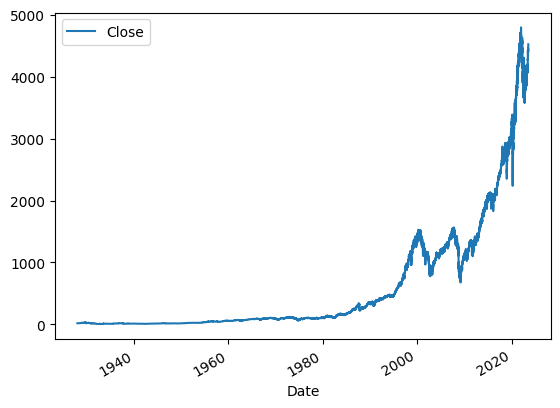

In [48]:
# Getting historical data for stock / index
stock = yf.Ticker("^GSPC")
stock = stock.history(period="max")
stock.plot.line(y="Close", use_index=True)

In [49]:
# Removing dividends and stock splits columns
del stock["Dividends"]
del stock["Stock Splits"]

# New column indicates if tomorrow's closing price > today's
stock["Tomorrow"] = stock["Close"].shift(-1)
stock["Target"] = (stock["Tomorrow"] > stock["Close"]).astype(int)

# Using recent data due to market shift
stock = stock.loc["1990-01-01":].copy()
stock

,Open,High,Low,Close,Volume,Tomorrow,Target
Date,,,,,,,
1990-01-02 00:00:00-05:00,353.399994,359.690002,351.980011,359.690002,162070000,358.760010,0
1990-01-03 00:00:00-05:00,359.690002,360.589996,357.890015,358.760010,192330000,355.670013,0
1990-01-04 00:00:00-05:00,358.760010,358.760010,352.890015,355.670013,177000000,352.200012,0
1990-01-05 00:00:00-05:00,355.670013,355.670013,351.350006,352.200012,158530000,353.790009,1
1990-01-08 00:00:00-05:00,352.200012,354.239990,350.540009,353.790009,140110000,349.619995,0
...,...,...,...,...,...,...,...
2023-07-11 00:00:00-04:00,4415.549805,4443.640137,4408.459961,4439.259766,3624220000,4472.160156,1
2023-07-12 00:00:00-04:00,4467.689941,4488.339844,4463.229980,4472.160156,3920290000,4510.040039,1
2023-07-13 00:00:00-04:00,4491.500000,4517.379883,4489.359863,4510.040039,3839530000,4505.419922,0


In [50]:
# Train the model and classify predictions as 1 or 0 based on probability threshold
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict_proba(test[predictors])[:,1]
    preds[preds >= 0.6] = 1
    preds[preds < 0.6] = 0
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [51]:
# Function to backtest the model with a rolling window
def backtest(data, model, predictors, start=2500, step=250):
    all_predictions = []
    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)
    return pd.concat(all_predictions)

In [52]:
# New variables using different time horizons
horizons = [2,5,60,250,1000]
new_predictors = []

for horizon in horizons:
  rolling_averages = stock.rolling(horizon).mean()

  ratio_column = f"Close_Ratio_{horizon}"
  stock[ratio_column] = stock["Close"] / rolling_averages["Close"]

  trend_column = f"Trend_{horizon}"
  stock[trend_column] = stock.shift(1).rolling(horizon).sum()["Target"]

  new_predictors += [ratio_column, trend_column]

In [53]:
# Dropping rows with missing values
stock = stock.dropna()

In [54]:
# Initializing Random Forest model
model = RandomForestClassifier(n_estimators=300, min_samples_split=50, random_state=1)

In [55]:
# Running the backtest
predictions = backtest(stock, model, new_predictors)

In [56]:
# Counting the number of 0's and 1's in the predictions
predictions["Predictions"].value_counts()

Predictions
0.0    4162
1.0     786
Name: count, dtype: int64

In [57]:
# Calculating the precision score
precision_score(predictions["Target"], predictions["Predictions"])

0.5687022900763359

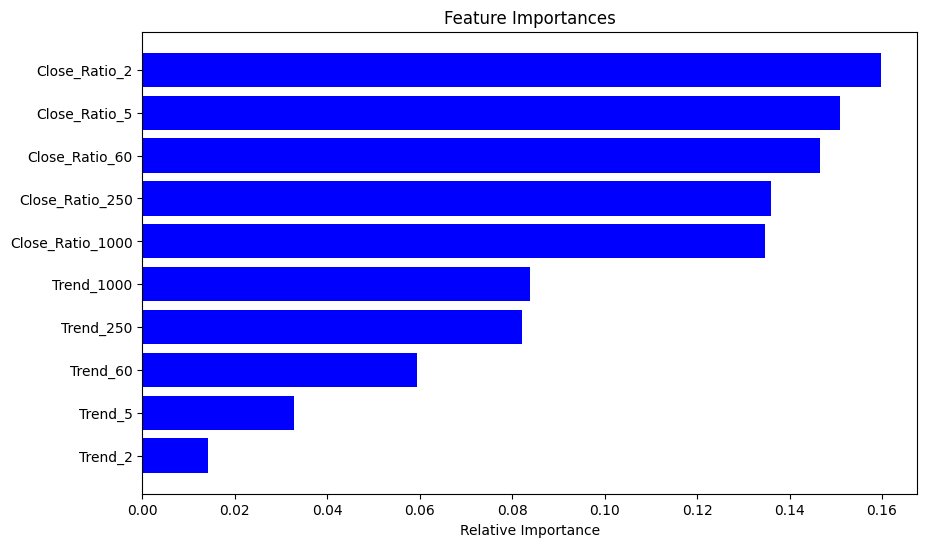

In [58]:
# Feature Importance Bar Plot
importances = model.feature_importances_
indices = np.argsort(importances)
plt.figure(figsize=(10, 6))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [new_predictors[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()


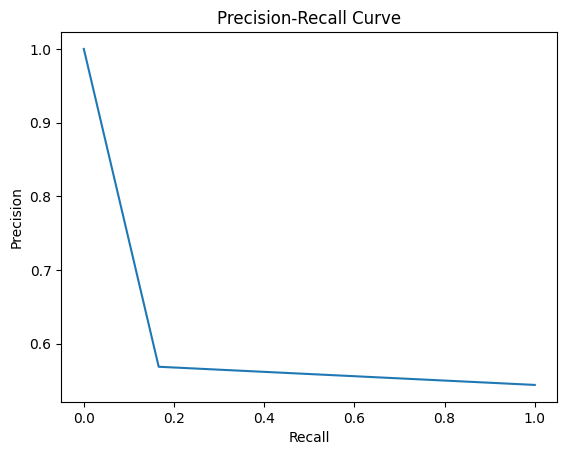

In [59]:
from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(predictions["Target"], predictions["Predictions"])
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()


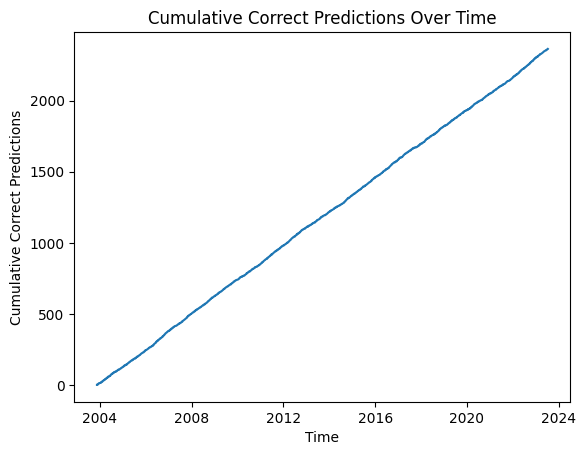

In [60]:
predictions['Correct Predictions'] = predictions['Target'] == predictions['Predictions']
predictions['Correct Predictions'] = predictions['Correct Predictions'].astype(int)
predictions['Strategy Equity'] = predictions['Correct Predictions'].cumsum()

plt.plot(predictions.index, predictions['Strategy Equity'])
plt.xlabel('Time')
plt.ylabel('Cumulative Correct Predictions')
plt.title('Cumulative Correct Predictions Over Time')
plt.show()

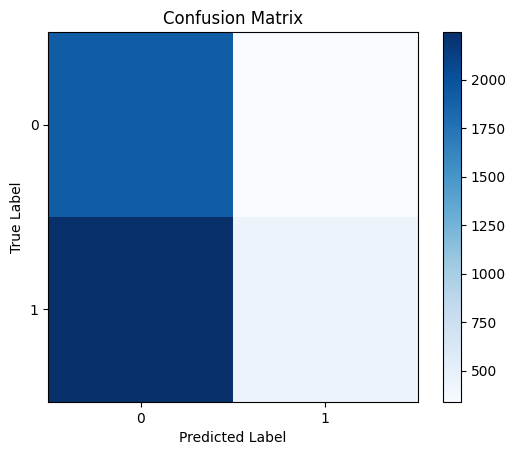

In [61]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
cm = confusion_matrix(predictions["Target"], predictions["Predictions"])
plt.imshow(cm, cmap='Blues')
plt.title("Confusion Matrix")
plt.colorbar()
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.xticks([0, 1], labels=["0", "1"])
plt.yticks([0, 1], labels=["0", "1"])
plt.show()

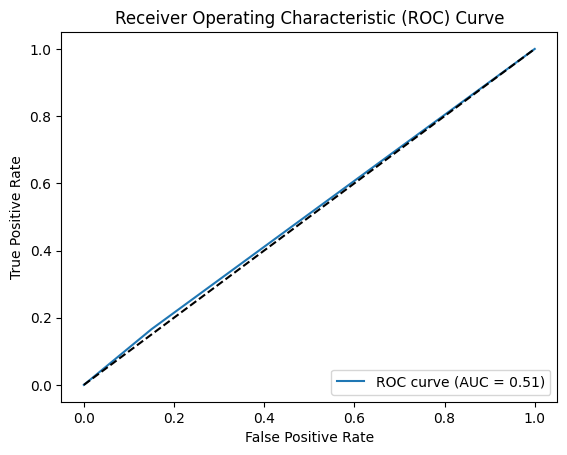

In [62]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(predictions["Target"], predictions["Predictions"])
roc_auc = roc_auc_score(predictions["Target"], predictions["Predictions"])
plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [70]:
# Calculate daily returns
stock.loc[:, "Returns"] = stock["Close"].pct_change()

# Calculate cumulative returns
stock.loc[:, "Cumulative Returns"] = (1 + stock["Returns"]).cumprod()

# Calculate annualized returns
start_date = stock.index[0]
end_date = stock.index[-1]
total_days = (end_date - start_date).days
total_years = total_days / 365
total_return = stock["Cumulative Returns"].iloc[-1]
average_annual_return = (total_return ** (1 / total_years) - 1) * 100

# Calculate Sharpe Ratio
risk_free_rate = 0.03  # Assuming a risk-free rate of 3%
daily_returns = stock["Returns"].dropna()
excess_returns = daily_returns - risk_free_rate / 252
annualized_excess_return = np.mean(excess_returns) * 252
annualized_volatility = daily_returns.std() * np.sqrt(252)  # Assuming 252 trading days in a year
sharpe_ratio = annualized_excess_return / annualized_volatility

# Calculate Maximum Drawdown
stock.loc[:, "Peak"] = stock["Cumulative Returns"].cummax()
stock.loc[:, "Drawdown"] = (stock["Cumulative Returns"] - stock["Peak"]) / stock["Peak"]
max_drawdown = stock["Drawdown"].min() * 100

# Convert predictors to numeric array
predictor_data = stock[new_predictors].values

# Assuming you have trained your model and obtained predictions
predictions = model.predict(predictor_data)

# Make buy and sell decisions based on predictions
stock.loc[:, "Predictions"] = predictions

# Calculate number of trades
trade_signals = stock["Predictions"].values.astype(int)
trades = 0
holding_stock = False

for i in range(len(trade_signals)):
    if trade_signals[i] == 1 and not holding_stock:
        # We have a 'buy' signal and currently not holding stock, so we buy
        holding_stock = True
    elif trade_signals[i] == 0 and holding_stock:
        # We have a 'sell' signal and currently holding stock, so we sell
        holding_stock = False
        trades += 1  # Only increase trade count when we sell

number_of_trades = trades

print(f"Average Annual Return: {average_annual_return:.2f}%")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"Maximum Drawdown: {max_drawdown:.2f}%")
print(f"Number of Trades: {number_of_trades}")



c:\Users\andyb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Average Annual Return: 7.99%
Sharpe Ratio: 0.34
Maximum Drawdown: -56.78%
Number of Trades: 1674
